In [ ]:
pip install d2l==0.17.6

## softmax函数能够将未规范化的预测变换为非负数并且总和为1，同时让模型保持可导的性质

做法是：
首先对每个未规范化的预测求幂，这样可以确保输出非负值。
为了确保最终输出的概率总和为1，我们再让每个求幂后的结果处以结果的总和

交叉熵分类的目标：（1）最大化观测数据的似然；（2）最小化传达标签所需的惊异

# 3.5 图像分类数据集

In [ ]:
%matplotlib inline
import torch
import torchvision
from torch.utils import data
from torchvision import transforms
from d2l import torch as d2l

d2l.use_svg_display()

# 读取数据集
trans = transforms.ToTensor() # 转换为tensor张量形式
mnist_train = torchvision.datasets.FashionMNIST(root="../data", train=True, transform=trans, download=True) # 训练集
mnist_test = torchvision.datasets.FashionMNIST(root="../data", train=False, transform=trans, download=True) # 测试集

len(mnist_train), len(mnist_test)
mnist_train[0][0].shape

def get_fashion_mnist_labels(labels):
  '''返回Fashion-MNIST数据集的文本标签'''
  text_labels = ['t-shirt', 'trouser', 'pullover', 'dress', 'coat', 'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot']
  return [text_labels[int(i)] for i in labels]

# 可视化样本
def show_images(imgs, num_rows, num_cols, titles=None, scale=1.5):
  '''绘制图像列表'''
  figsize = (num_cols * scale, num_rows * scale)
  _, axes = d2l.plt.subplots(num_rows, num_cols, figsize=figsize)
  axes = axes.flatten()
  for i, (ax, img) in enumerate(zip(axes, imgs)):
    if torch.is_tensor(img):
      # 图像张量
      ax.imshow(img.numpy())
    else:
      # PIL图像
      ax.imshow(img)
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)
    if titles:
      ax.set_title(titles[i])
  return axes

  X, y = next(iter(data.DataLoader(mnist_train, batch_size=18)))
  show_images(X.reshape(18, 28, 28), 2, 9, titles=get_fashion_mnist_labels(y));

In [ ]:
# 读取小批量
batch_size = 256
def get_dataloader_workers():
  '''使用2个进程来读取数据'''
  return 2

train_iter = data.DataLoader(mnist_train, batch_size, shuffle=True, num_workers=get_dataloader_workers())

timer = d2l.Timer()
for X,y in train_iter:
  continue
f'{timer.stop():.2f} sec'


'8.94 sec'

In [ ]:
# 整合所有组件
def load_data_fashion_mnist(batch_size, resize=None):
  '''下载Fashion-MNIST数据集，然后加载到内存中'''
  trans = [transforms.ToTensor()]
  if resize:
    trans.insert(0, transforms.Resize(resize))
  trans = transforms.Compose(trans)
  mnist_train = torchvision.datasets.FashionMNIST(root="../data", train=True, transform=trans, download=True)
  mnist_train = torchvision.datasets.FashionMNIST(root="../data", train=False, transform=trans, download=True)
  return (data.DataLoader(mnist_train, batch_size, shuffle=True, num_workers=get_dataloader_workers()),
          data.DataLoader(mnist_test, batch_size, shuffle=False, num_workers=get_dataloader_workers()))

train_iter, test_iter = load_data_fashion_mnist(32, resize=64)
for X, y in train_iter:
  print(X.shape, X.dtype, y.shape, y.dtype)
  break

torch.Size([32, 1, 64, 64]) torch.float32 torch.Size([32]) torch.int64


# 3.6 softmax回归从零开始实现

In [31]:
import torch
from IPython import display
from d2l import torch as d2l

batch_size = 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)

# 初始化模型参数
num_inputs = 784
num_outputs = 10

W = torch.normal(0, 0.01, size=(num_inputs, num_outputs), requires_grad=True)
b = torch.zeros(num_outputs, requires_grad=True)

# 定义softmax操作
X = torch.tensor([[1.0, 2.0, 3.0], [4.0, 5.0, 6.0]])
X.sum(0, keepdim=True), X.sum(1, keepdim=True)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


(tensor([[5., 7., 9.]]),
 tensor([[ 6.],
         [15.]]))

In [32]:
def softmax(X):
  X_exp = torch.exp(X)
  partition = X_exp.sum(1, keepdim=True)
  return X_exp / partition

X = torch.normal(0, 1, (2, 5))
X_prob = softmax(X)
X_prob, X_prob.sum(1)

(tensor([[0.2376, 0.2144, 0.1852, 0.1745, 0.1884],
         [0.0281, 0.0701, 0.2076, 0.1140, 0.5802]]),
 tensor([1., 1.]))

In [33]:
# 定义模型
def net(X):
  return softmax(torch.matmul(X.reshape((-1, W.shape[0])), W) + b)

# 定义损失函数
y = torch.tensor([0, 2])
y_hat = torch.tensor([[0.1, 0.3, 0.6], [0.3, 0.2, 0.5]])
y_hat[[0, 1], y]

def cross_entropy(y_hat, y):
  return - torch.log(y_hat[range(len(y_hat)), y])

cross_entropy(y_hat, y)

tensor([2.3026, 0.6931])

In [34]:
# 分类精度
def accuracy(y_hat, y):
  '''计算预测正确的数量'''
  if len(y_hat.shape) > 1 and y_hat.shape[1] > 1:
    y_hat = y_hat.argmax(axis=1)
  cmp = y_hat.type(y.dtype) == y
  return float(cmp.type(y.dtype).sum())

accuracy(y_hat, y) / len(y)

0.5

In [35]:
def evaluate_accuracy(net, data_iter):
  '''计算在指定数据集上模型的精度'''
  if isinstance(net, torch.nn.Module):
    net.eval() # 将模型设置为评估模式
  metric = Accumulator(2) # 正确预测数、预测总数
  with torch.no_grad():
    for X, y in data_iter:
      metric.add(accuracy(net(X), y), y.numel())
  return metric[0] / metric[1] # 分类正确样本和总样本数

class Accumulator:
  '''在n个变量上累加'''
  def __init__(self, n):
    self.data = [0.0] * n

  def add(self, *args):
    self.data = [a + float(b) for a, b in zip(self.data, args)]

  def reset(self):
    self.data = [0.0] * len(self.data)

  def __getitem__(self, idx):
    return self.data[idx]

evaluate_accuracy(net, test_iter)


0.1304

IndexError: ignored

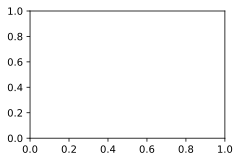

In [38]:
# 训练
def train_epoch_ch3(net, train_iter, loss, updater):
  '''训练模型一轮'''
  # 将模型设置为训练模式
  if isinstance(net, torch.nn.Module):
    net.train()
  # 训练损失总和、训练准确度总和、样本数
  metric = Accumulator(3)
  for X, y in train_iter:
    # 计算梯度并更新参数
    y_hay = net(X)
    l = loss(y_hat, y)
    if isinstance(updater, torch.optim.Optimizer):
      # 使用Pytorch内置的优化器和损失函数
      updater.zero_grad()
      l.mean().backward()
      updater.step()
    else:
      # 使用定制的优化器和损失函数
      l.sum().backward()
      updater(X.shape[0])
    metric.add(float(l.sum()), accuracy(y_hat, y), y.numel())
  # 返回训练损失和训练精度
  return metric[0] / metric[2], metric[1] / metric[2]

# 动画展示
class Animator:
  '''在动画中绘制数据'''
  def __init__(self, xlabel=None, ylabel=None, legend=None, xlim=None, ylim=None, xscale='linear', yscale='linear', fmts=('-', 'm--', 'g-', 'r:'), nrows=1, ncols=1, figsize=(3.5, 2.3)):
    # 增量地绘制多条线
    if legend is None:
      legend = []
    d2l.use_svg_display()
    self.fig, self.axes = d2l.plt.subplots(nrows, ncols, figsize=figsize)
    if nrows * ncols == 1:
      self.axes = [self.axes, ]
    # 使用lambda函数捕获参数
    self.config_axes = lambda: d2l.set_axes(self.axes[0], xlabel, ylabel, xlim, ylim, xscale, yscale, legend)
    self.X, self.Y, self.fmts = None, None, fmts

  def add(self, x, y):
    # 向图表中添加多个数据点
    if not hasattr(y, "__len__"):
      y = [y]
    n = len(y)
    if not hasattr(x, "__len__"):
      x = [x] * n
    if not self.X:
      self.X =[[] for _ in range(n)]
    if not self.Y:
      self.X =[[] for _ in range(n)]
    for i, (a,b) in enumerate(zip(x, y)):
      if a is not None and b is not None:
        self.X[i].append(a)
        self.Y[i].append(b)
    self.axes[0].cla()
    for x, y, fmt in zip(self.X, self.Y, self.fmts):
      self.axes[0].plot(x, y, fmt)
    self.config_axes()
    display.display(self.fig)
    display.clear_output(wait=True)

# 训练函数
def train_ch3(net, train_iter, test_iter, loss, num_epochs, updater):
  '''训练模型'''
  animator = Animator(xlabel='epoch', xlim=[1, num_epochs], ylim=[0.3, 0.9], legend=['train_loss', 'train_acc', 'test_acc'])
  for epoch in range(num_epochs):
    train_metrics = train_epoch_ch3(net, train_iter, loss, updater)
    test_acc = evaluate_accuracy(net, test_iter)
    animator.add(epoch+1, train_metrics + (test_acc, ))
  train_loss, train_acc = train_metrics
  assert train_loss < 0.5, train_loss
  assert train_acc <= 1 and train_acc > 0.7, train_acc
  assert test_acc <= 1 and test_acc > 0.7, test_acc

lr = 0.1
def updater(batch_size):
  return d2l.sgd([W,b], lr, batch_size)

num_epochs = 10
train_ch3(net, train_iter, test_iter, cross_entropy, num_epochs, updater)

In [ ]:
# 预测
def predict_ch3(net, test_iter, n=6):
  '''预测标签'''
  for X, y in test_iter:
    break
  trues = d2l.get_fashion_mnist_labels(y)
  preds = d2l.get_fashion_mnist_labels(net(X).argmax(axis=1))
  titles = [true + '\n' + pred for true, pred in zip(trues, preds)]
  d2l.show_images(X[0:n].reshape((n, 28, 28)), 1, n, titles=titles[0:n])

predict_ch3(net, test_iter)

## 3.7 softmax回归的简洁实现

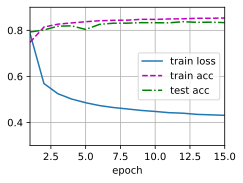

In [41]:
import torch
from torch import nn
from d2l import torch as d2l

batch_size = 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)

# 初始化模型参数
net = nn.Sequential(nn.Flatten(), nn.Linear(784, 10))

def init_weights(m):
  '''m layers'''
  if type(m) == nn.Linear:
    nn.init.normal_(m.weight, std=0.01)

net.apply(init_weights);

loss = nn.CrossEntropyLoss(reduction='none')

trainer = torch.optim.SGD(net.parameters(), lr=0.1)

num_epochs = 15
d2l.train_ch3(net, train_iter, test_iter, loss, num_epochs, trainer)